In [3]:
import sys
sys.path.append('../rovbase')

from CloseToAttack import calculate_distance
from datetime import timedelta
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sb


In [4]:
df2015 = pd.read_csv('../data/kaasa/kaasa_2015.csv', index_col=None, header=0)
df2016 = pd.read_csv('../data/kaasa/kaasa_2016.csv', index_col=None, header=0)
df2017 = pd.read_csv('../data/kaasa/kaasa_2017.csv', index_col=None, header=0)
df2018 = pd.read_csv('../data/kaasa/kaasa_2018.csv', index_col=None, header=0)
df2019 = pd.read_csv('../data/kaasa/kaasa_2019.csv', index_col=None, header=0)
df2020 = pd.read_csv('../data/kaasa/kaasa_2020.csv', index_col=None, header=0)
df2021 = pd.read_csv('../data/kaasa/kaasa_2021.csv', index_col=None, header=0)

files = [df2015, df2016, df2017, df2018, df2019, df2020, df2021]

df = pd.concat(files, axis=0, ignore_index=True)
df1 = df.loc[:,['altitude', 'angle', 'velocity', 'temperature', 'attack']]

attack_df = df1[df1['attack'] == 1]
no_attack_df = df1[df1['attack'] == 0]

attack_data = pd.read_csv('../data/rovbase/rovviltskader.csv')


In [5]:
print(attack_df.describe())
print(attack_df.describe())


          altitude        angle     velocity  temperature  attack
count  3386.000000  3386.000000  3386.000000  3386.000000  3386.0
mean    400.976533   103.033831    76.668340    11.703308     1.0
std     203.106494    55.881343   125.444268     4.628056     0.0
min     185.020000     0.000000     0.000000     0.300000     1.0
25%     230.182500    53.554898    10.000000     8.500000     1.0
50%     335.085000   112.910731    31.000000    10.900000     1.0
75%     482.150000   153.744972    95.000000    14.400000     1.0
max     829.240000   180.000000  2338.000000    25.100000     1.0
          altitude        angle     velocity  temperature  attack
count  3386.000000  3386.000000  3386.000000  3386.000000  3386.0
mean    400.976533   103.033831    76.668340    11.703308     1.0
std     203.106494    55.881343   125.444268     4.628056     0.0
min     185.020000     0.000000     0.000000     0.300000     1.0
25%     230.182500    53.554898    10.000000     8.500000     1.0
50%     33

# Flock behaviour before, during and after an attack

In [6]:


# Create flock that is nearby an attack, return list of individuals in the flock
def create_flock(sheep_data, attack):

    # Get attack start and end date
    attack_start_date = attack['date_from'].date()
    attack_end_date = attack['date_to'].date()

    # Only sheep in an attack will be in a flock nearby an attack
    sheep_data = sheep_data[sheep_data['attack'] == 1]

    # Each index corresponds to a row in the sheep data where date is within the attack dates
    sheep_indexes = sheep_data.loc[(attack_start_date <= sheep_data['date']) & (
        sheep_data['date'] <= attack_end_date)].index

    flock = []  # the flock nearby the attack

    for sheep in sheep_indexes:
        # Get latitude and longitude for sheep and attack
        sheep_lat = sheep_data.at[sheep, 'latitude']
        sheep_long = sheep_data.at[sheep, 'longitude']
        attack_lat = attack['latitude']
        attack_long = attack['longitude']

        # Calculate the distance from the sheep to the attack
        distance_to_attack = calculate_distance(
            sheep_lat, sheep_long, attack_lat, attack_long)

        if distance_to_attack <= 1500:  # The sheep is nearby the attack
            ind = sheep_data.at[sheep, 'individual']
            if ind not in flock:
                flock.append(ind)

    return flock


In [74]:
def get_values(sheep_data, flock, attack, feature):
    attack_start_date = attack['date_from'].date()
    attack_end_date = attack['date_to'].date()

    day_before = attack_start_date - timedelta(days=1)
    day_after = attack_end_date + timedelta(days=1)

    on_attack_feature = pd.Series(dtype='int64')
    before_feature = pd.Series(dtype='int64')
    after_feature = pd.Series(dtype='int64')


    for ind in flock:  # Loop through to get the feature from every sheep in the flock before and after attack
        on_attack = sheep_data.loc[(attack_start_date <= sheep_data['date']) & (
                 sheep_data['date'] <= attack_end_date) & (sheep_data['individual'] == ind)]
        before = sheep_data.loc[(sheep_data['date'] == day_before) & (sheep_data['individual'] == ind)]
        after = sheep_data.loc[(sheep_data['date'] == day_after) & (sheep_data['individual'] == ind)]


        if len(on_attack) > 0:
            on_attack_feature = pd.concat(
                [on_attack_feature, on_attack[feature]])
        if len(before) > 0:
            before_feature = pd.concat([before_feature, before[feature]])
        if len(after) > 0:
            after_feature = pd.concat([after_feature, after[feature]])


    df = pd.concat([before_feature, on_attack_feature, after_feature],
                     axis=1, keys=['Before', 'During', 'After'])


   
    return df


In [75]:
def create_df(sheep_data, attack_data, feature):
    attack_data['date_from'] = pd.to_datetime(attack_data['date_from'])
    attack_data['date_to'] = pd.to_datetime(attack_data['date_to'])

    # create new column with only date
    sheep_data['date'] = pd.to_datetime(sheep_data['date_time']).dt.date

    feature_df = pd.DataFrame(
        columns=['Before', 'During', 'After'])
  

    for a in attack_data.index:
        attack = attack_data.iloc[a]  # Get attack row
        flock = create_flock(sheep_data, attack)

        if len(flock) != 0:
            new_rows = get_values(
                sheep_data, flock, attack, feature)

            feature_df = pd.concat(
                [feature_df, new_rows], ignore_index=True, axis=0)
         

    return feature_df


# For all data

## Velocity

In [76]:
velocity_df = create_df(
    sheep_data=df, attack_data=attack_data, feature='velocity')

            Before        During         After
count  3124.000000   8188.000000   3354.000000
mean    107.025928    130.935515    151.523554
std     219.992643    483.561961    520.427729
min       0.000000      0.000000      0.000000
25%      17.000000     12.000000     13.000000
50%      56.000000     49.000000     49.000000
75%     143.000000    147.000000    153.750000
max    4650.000000  12973.000000  12973.000000


Text(0, 0.5, 'Velocity')

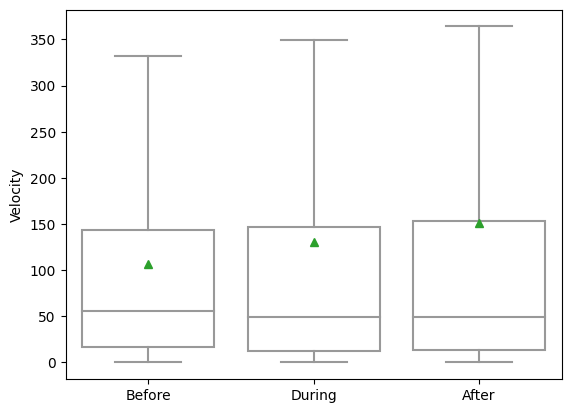

In [110]:
print(velocity_df.describe())
ax = sb.boxplot(data=velocity_df,
                showfliers=False, showmeans=True, color="White")
ax.set_ylabel('Velocity')



Text(0, 0.5, 'Velocity')

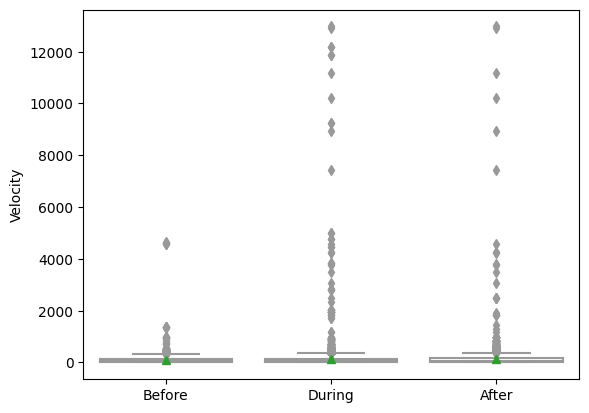

In [82]:
ax = sb.boxplot(data=velocity_df,
                showfliers=True, showmeans=True, color="White")
ax.set_ylabel('Velocity')

print()

## Altitude

            Before       During        After
count  3124.000000  8188.000000  3354.000000
mean    476.097458   498.704034   478.138798
std     211.588718   227.738905   243.951645
min     180.070000    92.620000    92.620000
25%     288.532500   269.880000   247.595000
50%     416.100000   448.475000   383.640000
75%     688.197500   721.700000   759.020000
max     821.880000   892.580000   861.330000


Text(0, 0.5, 'Altitude')

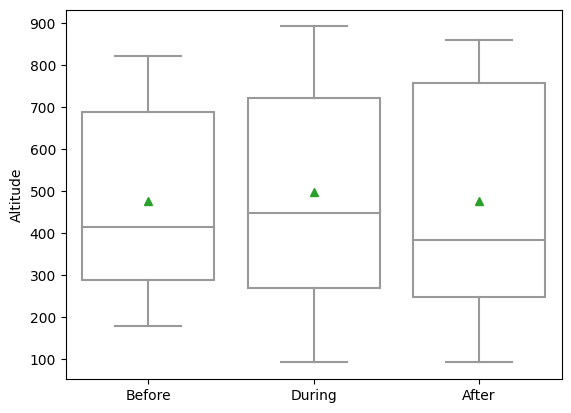

In [85]:
altitude_df = create_df(sheep_data=df, attack_data=attack_data, feature='altitude')

print(altitude_df.describe())


ax = sb.boxplot(data=altitude_df,
                showfliers=False, showmeans=True, color="White")
ax.set_ylabel('Altitude')


# Angle

            Before       During        After
count  3124.000000  8188.000000  3354.000000
mean     97.139840    99.654683    98.647687
std      59.145986    56.674158    57.407180
min       0.044381     0.000000     0.000000
25%      40.191169    48.701187    45.749412
50%     105.658338   108.467906   102.867784
75%     153.153858   151.943569   153.686144
max     180.000000   180.000000   180.000000


Text(0, 0.5, 'Angle')

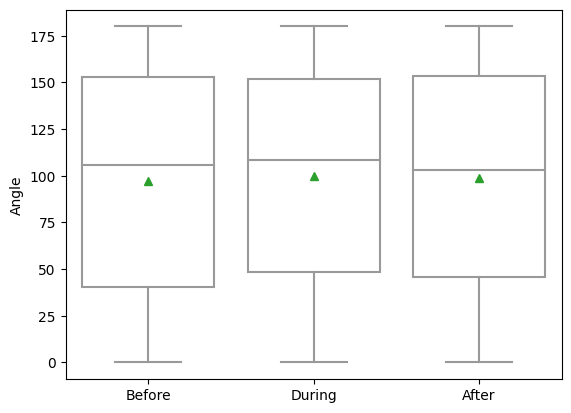

In [79]:
angle_df = create_df(sheep_data=df, attack_data=attack_data, feature='angle')

print(angle_df.describe())


ax = sb.boxplot(data=angle_df,
                showfliers=False, showmeans=True, color="White")
ax.set_ylabel('Angle')


# Distanse mellom første og siste punkt 
Vi vil regne ut distansen mellom første og siste punkt for hver sau på den dagen det er angrep. Dette blir gjort på hver sau i en flokk, slik at vi får se hvor langt flokken har bevegeset seg fra start til slutt på dagen før angrep, angrepsdagen og dagen etter.

In [88]:
import numpy as np

def create_mean_std_distance(sheep_data, attack_data):
    df = pd.DataFrame(columns=['before_dist', 'attack_dist','after_dist'])


    for a in attack_data.index:
        attack = attack_data.loc[a]
        flock = create_flock(sheep_data, attack)
        if len(flock) == 0:
            continue

        attack_start_date = attack['date_from'].date()
        attack_end_date = attack['date_to'].date()

        day_before = attack_start_date - timedelta(days=1)
        day_after = attack_end_date + timedelta(days=1)

        for ind in flock:
            on_attack = sheep_data.loc[(attack_start_date <= sheep_data['date']) & (
                sheep_data['date'] <= attack_end_date) & (sheep_data['individual'] == ind)]
            before = sheep_data.loc[(sheep_data['date'] == day_before) & (
                sheep_data['individual'] == ind)]
            after = sheep_data.loc[(sheep_data['date'] == day_after) & (
                sheep_data['individual'] == ind)]
            

            dist_on_attack = get_dist_between_first_last_row(
                on_attack) if len(on_attack) > 0 else np.nan
            dist_before = get_dist_between_first_last_row(
                before) if len(before) > 0 else np.nan
            dist_after = get_dist_between_first_last_row(
                after) if len(after) > 0 else np.nan
            
            row = pd.DataFrame(
                columns=['before_dist', 'attack_dist','after_dist'])
            row.at[0, 'before_dist'] = dist_before
            row.at[0, 'after_dist'] = dist_after
            row.at[0,'attack_dist'] = dist_on_attack

            df = pd.concat(
                [df,row], ignore_index=True, axis=0)


    return df


def get_dist_between_first_last_row(df):
    first_date = df.iloc[0]
    last_date = df.iloc[-1]
    first_lat = first_date['latitude']
    first_long = first_date['longitude']
    last_lat = last_date['latitude']
    last_long = last_date['longitude']

    dist = calculate_distance(first_lat, first_long, last_lat, last_long)

    return dist


In [94]:
distance_df = create_mean_std_distance(sheep_data=df, attack_data=attack_data)
#distance_df = distance_df.drop_duplicates(['num_ind',  'mean_distance', 'std_distance', 'before_mean_distance','before_std_distance', 'after_mean_distance', 'after_std_distance'], ignore_index=True)
distance_df
distance_df['before_dist'] = pd.to_numeric(distance_df['before_dist'])
distance_df['after_dist'] = pd.to_numeric(distance_df['after_dist'])
distance_df['attack_dist'] = pd.to_numeric(distance_df['attack_dist'])


## Distance

       before_dist  attack_dist   after_dist
count   548.000000   548.000000   541.000000
mean    666.447673   951.811974  1510.815802
std    1128.031990  1072.995738  1422.366595
min       0.000000     3.021554     0.000000
25%     113.713479   180.034020   177.409546
50%     292.161796   733.569134   994.439384
75%     717.210866  1194.874569  2536.225765
max    7964.541068  5753.914849  6113.640718


Text(0, 0.5, 'Distance')

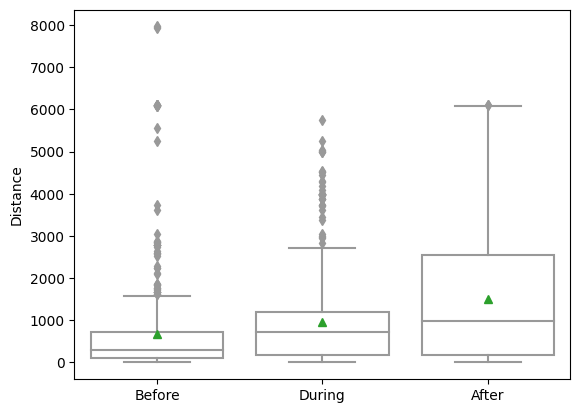

In [100]:

print(distance_df.describe())

velocity_dis = distance_df.rename(columns={
    'before_dist': 'Before', 'attack_dist': 'During', 'after_dist': 'After'})



ax = sb.boxplot(data=velocity_dis,
                showfliers=True, showmeans=True, color="White")
ax.set_ylabel('Distance')



Text(0, 0.5, 'Distance')

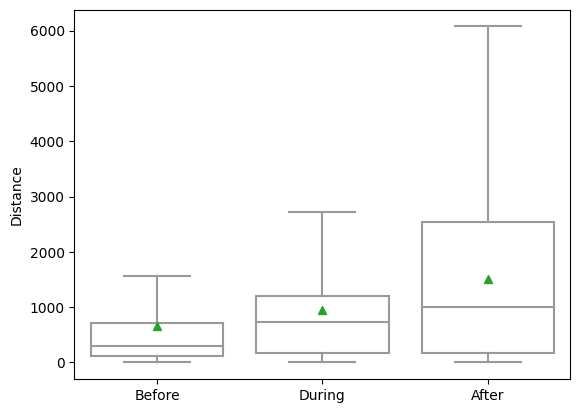

In [98]:
ax = sb.boxplot(data=velocity_dis,
                showfliers=False, showmeans=True, color="White")
ax.set_ylabel('Distance')


Text(0, 0.5, 'Distance')

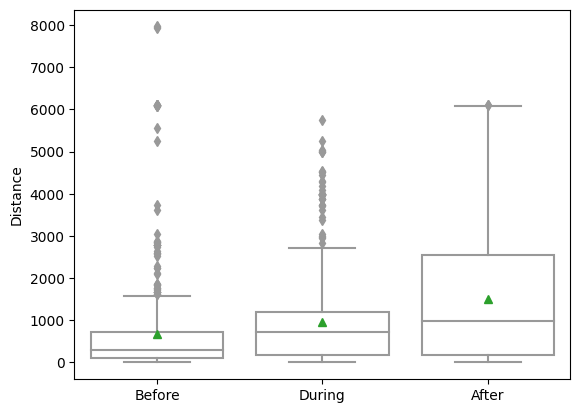

In [99]:
ax = sb.boxplot(data=velocity_dis,
                showfliers=True, showmeans=True, color="White")
ax.set_ylabel('Distance')


# Distance all sheep

In [27]:
def get_distances(sheep_data):
    # Create new column with only date
    sheep_data['date'] = pd.to_datetime(sheep_data['date_time']).dt.date

    # Loop through unique sheep and dates to calculate distance
    distance = []
    for ind in sheep_data['individual'].unique():
        for date in sheep_data['date'].unique():
            on_day = sheep_data.loc[(sheep_data['date'] == date) & (
                sheep_data['individual'] == ind)]
            if len(on_day) > 0:
                distance = calculate_distance(on_day.iloc[0]['latitude'], on_day.iloc[0]['longitude'],
                                                    on_day.iloc[-1]['latitude'], on_day.iloc[-1]['longitude'])
                distance.append(distance)

    # Return distances as pandas series
    return pd.Series(distance)


In [33]:
distance_attacks2021 = get_distances(sheep_data=df2021)

In [34]:
distance_attacks2020 = get_distances(sheep_data=df2020)


In [35]:
distance_attacks2019 = get_distances(sheep_data=df2019)


In [36]:
distance_attacks2018 = get_distances(sheep_data=df2018)


In [37]:
distance_attacks2017 = get_distances(sheep_data=df2017)

In [38]:
distance_attacks2016 = get_distances(sheep_data=df2016)

In [39]:
distance_attacks2015 = get_distances(sheep_data=df2015)


In [43]:
total_dist = pd.concat(
    [distance_attacks2015, distance_attacks2016, distance_attacks2017, distance_attacks2018, distance_attacks2019, distance_attacks2020, distance_attacks2021], axis=0, ignore_index=True)
print(total_dist)




0          74.673379
1         167.387174
2         131.978368
3         103.568672
4          16.105935
            ...     
41239    1457.820287
41240     841.919258
41241     233.370495
41242    2070.700213
41243    3113.459864
Length: 41244, dtype: float64


count    41244.000000
mean       648.544465
std        907.901106
min          0.000000
25%         84.091667
50%        338.240933
75%        826.560798
max      32006.097552
dtype: float64


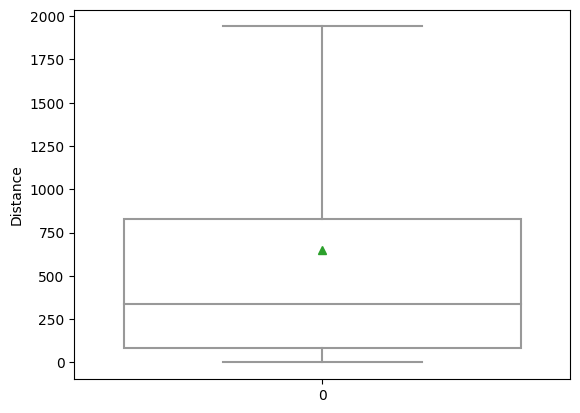

In [45]:
ax = sb.boxplot(data=total_dist,
                showfliers=False, showmeans=True, color="White")
ax.set_ylabel('Distance')
print(total_dist.describe())


In [ ]:
ax = sb.boxplot(data=total_dist,
                showfliers=False, showmeans=True, color="White")
ax.set_ylabel('Distance')
print(total_dist.describe())
